In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
import sys

sys.path.append('/kaggle/input/haarpsi')

import pickle
from haarPsi import *
from PIL import Image
import cv2
import pywt
from tqdm import tqdm
from numba import njit
from sklearn.metrics import *
from sklearn.cluster import spectral_clustering
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
def aa(path):
    data = pd.DataFrame(columns=['image', 'label', 'distortion type', "distorion's level"])
    imlist = [(os.path.join(path, f), int(f[1:3]), int(f[4: 6]), int(f[7 : 8])) 
              for f in os.listdir(path) if f.endswith('.bmp') or f.endswith('.BMP')]
    for i, f in tqdm(enumerate(imlist)):
        print(f)
        im = Image.open(f[0])
        im = np.array(im)
        #print(im)
        data.at[i, 'image'] = im
        data.at[i, 'label'] = f[1]
        data.at[i, 'distortion type'] = f[2]
        data.at[i, "distortion's level"] = f[3]
                      
    return data

In [4]:
info = pd.read_csv('/kaggle/input/tid2013/image_labeled_by_per_noise.csv')

In [5]:
def noise_type(x):
    l = [(1, 'Additive Gaussian noise'),
(2,'Additive noise in color components is more intensive than additive noise in the luminance component'),
(3,'Spatially correlated noise'),
(4,'Masked noise'),
(5,'High frequency noise'),
(6,'Impulse noise'),
(7,'Quantization noise'),
(8,'Gaussian blur'),
(9,'Image denoising'),
(10,'JPEG compression'),
(11,'JPEG2000 compression'),
(12,'JPEG transmission errors'),
(13,'JPEG2000 transmission errors'),
(14,'Non eccentricity pattern noise'),
(15,'Local block-wise distortions of different intensity'),
(16,'Mean shift (intensity shift)'),
(17,'Contrast change'),
(18,'Change of color saturation'),
(19,'Multiplicative Gaussian noise'),
(20,'Comfort noise'),
(21,'Lossy compression of noisy images'),
(22,'Image color quantization with dither'),
(23,'Chromatic aberrations'),
(24,'Sparse sampling and reconstruction')
]
    
    for i in l:
        if x == i[0]:
            return i[1]

In [6]:
def dist_type(x):
    return x[7:8]

In [7]:
info['noise_type'] = info['noise'].apply(noise_type)

In [8]:
info['distortion level'] = info['image'].apply(dist_type)

In [9]:
info.noise_type.unique()

array(['Additive Gaussian noise',
       'Additive noise in color components is more intensive than additive noise in the luminance component',
       'Spatially correlated noise', 'Masked noise',
       'High frequency noise', 'Impulse noise', 'Quantization noise',
       'Gaussian blur', 'Image denoising', 'JPEG compression',
       'JPEG2000 compression', 'JPEG transmission errors',
       'JPEG2000 transmission errors', 'Non eccentricity pattern noise',
       'Local block-wise distortions of different intensity',
       'Mean shift (intensity shift)', 'Contrast change',
       'Change of color saturation', 'Multiplicative Gaussian noise',
       'Comfort noise', 'Lossy compression of noisy images',
       'Image color quantization with dither', 'Chromatic aberrations',
       'Sparse sampling and reconstruction'], dtype=object)

In [10]:
info

,dmos,image,noise,reference,noise_type,distortion level
0,0.612699,I01_01_1.bmp,1,1,Additive Gaussian noise,1
1,0.618619,i01_01_2.bmp,1,1,Additive Gaussian noise,2
2,0.549382,i01_01_3.bmp,1,1,Additive Gaussian noise,3
3,0.486487,i01_01_4.bmp,1,1,Additive Gaussian noise,4
4,0.429429,i01_01_5.bmp,1,1,Additive Gaussian noise,5
...,...,...,...,...,...,...
2995,0.628571,i25_24_1.bmp,24,25,Sparse sampling and reconstruction,1
2996,0.604938,i25_24_2.bmp,24,25,Sparse sampling and reconstruction,2
2997,0.514286,i25_24_3.bmp,24,25,Sparse sampling and reconstruction,3
2998,0.447531,i25_24_4.bmp,24,25,Sparse sampling and reconstruction,4


In [11]:
list(info.loc[(info['noise'] == 4) & (info['reference'] == 1)]['image'])[0]

'i01_04_1.bmp'

In [12]:
print(np.array(Image.open('/kaggle/input/tid2013/distorted_images/I01_01_1.bmp')).shape)

(384, 512, 3)


In [13]:
def sim_matrix_haar_psi(data, size):
    
    sim_matrix = np.zeros([size, size])
    
    for i in tqdm(range(size)):
        
        for j in range(i, size):

            res = haar_psi(data[i], data[j])[0]
            
            sim_matrix[i][j], sim_matrix[j][i] = res, res
            
    return sim_matrix

In [14]:
def resize_for_haar_psi(data):
    
    return [np.resize(img, (80, 70)) for img in data]

In [15]:
def get_signal(img1, img2):
    
    widths = [18]

    cwtmatr1 = signal.cwt(img1, signal.ricker, widths)
    cwtmatr2 = signal.cwt(img2, signal.ricker, widths)
    
    return cwtmatr1, cwtmatr2

In [16]:
@njit(parallel=True)
def cw_ssim(cwtmatr1, cwtmatr2, k=0.01):
    
    c1c2_conj = np.multiply(cwtmatr1, np.conjugate(cwtmatr2))
    
    c1c2_sum = np.sum(c1c2_conj, axis=0)
    
    num_ssim = 2 * np.abs(c1c2_sum) + k
    
    c1_2 = np.square(np.abs(cwtmatr1))
    c2_2 = np.square(np.abs(cwtmatr2))
    
    den_ssim = np.sum(c1_2, axis=0) + np.sum(c2_2, axis=0) + k

    ssim_map = num_ssim / den_ssim

    # Average the per pixel results
    index = np.average(ssim_map)
    
    return index

In [17]:
def sim_matrix_cw(data, size):
    
    sim_m = np.zeros([size, size])
    
    for i in tqdm(range(size+1)):
        
        for j in range(i, size):
            
            cwtmatr1, cwtmatr2 = get_signal(data[i], data[j])
            
            res = cw_ssim(cwtmatr1, cwtmatr2)
            
            sim_m[i][j], sim_m[j][i] = res, res
            
            
    return sim_m

In [18]:
def haar_signal(img1, img2):
    
    coef1, freq1 = pywt.dwt2(img1, 'haar')
    coef2, freq2 = pywt.dwt2(img2, 'haar')
    
    return coef1, coef2

In [19]:
def matrix_cw_haar(data, size):
    sim_m = np.zeros([size, size])
    
    for i in tqdm(range(size+1)):
        
        for j in range(i, size):
            
            cwtmatr1, cwtmatr2 = haar_signal(data[i], data[j])
            
            res = cw_ssim(cwtmatr1, cwtmatr2)
            
            sim_m[i][j], sim_m[j][i] = res, res
            
            
    return sim_m

In [20]:
def check_for_noise_all(info):
    cw_r = {}
    cw_h = {}
    h_p = {}
    
    for i in range(1, 25):
        cw_r[i] = []
        cw_h[i] = []
        h_p[i] = []
    
    for noise in tqdm(range(1, 25)):
        for image in range(1, 26):
            im0 = np.array(Image.open('/kaggle/input/tid2013/distorted_images/' + list(info.loc[(info['noise'] == noise) & (info['reference'] == image)]['image'])[0]))
            
            for num in range(5):
                im = np.array(Image.open('/kaggle/input/tid2013/distorted_images/' + list(info.loc[(info['noise'] == noise) & (info['reference'] == image)]['image'])[num]))
                
                im_size = im.shape
                
                cw_ricker1, cw_ricker2 = get_signal(im0.flatten(), im.flatten())
                cw_r[noise].append(cw_ssim(cw_ricker1, cw_ricker2))

                cw_haar1, cw_haar2 = haar_signal(np.resize(im0, im_size), np.resize(im, im_size))
                cw_h[noise].append(cw_ssim(cw_haar1, cw_haar2))

                h_p[noise].append(haar_psi(np.resize(im0, im_size), 
                                            np.resize(im, im_size))[0])
                
    return cw_r, cw_h, h_p

In [21]:
r, h, p = check_for_noise_all(info)

100%|██████████| 24/24 [09:27<00:00, 23.63s/it]


In [22]:
x_r, y_r = zip(*r.items())
x_h, y_h = zip(*h.items())
x_p, y_p = zip(*p.items())

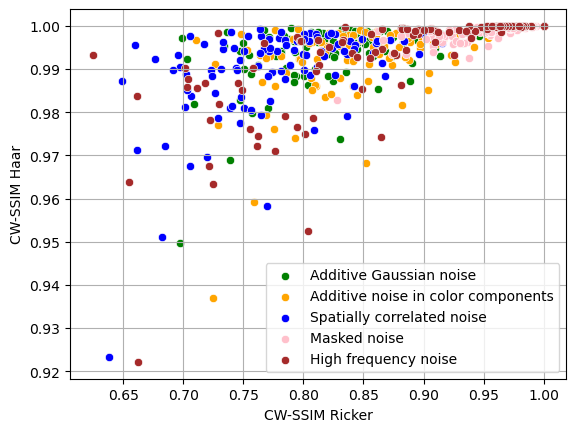

In [44]:
sns.scatterplot(x=y_r[0], y=y_h[0], marker='o', color='green', label='Additive Gaussian noise')
sns.scatterplot(x=y_r[1], y=y_h[1], marker='o', color='orange', label='Additive noise in color components')
sns.scatterplot(x=y_r[2], y=y_h[2], marker='o', color='blue', label='Spatially correlated noise')
sns.scatterplot(x=y_r[3], y=y_h[3], marker='o', color='pink', label='Masked noise')
sns.scatterplot(x=y_r[4], y=y_h[4], marker='o', color='brown', label='High frequency noise')
plt.xlabel('CW-SSIM Ricker')
plt.ylabel('CW-SSIM Haar')
plt.legend()
plt.grid(True)
plt.show()

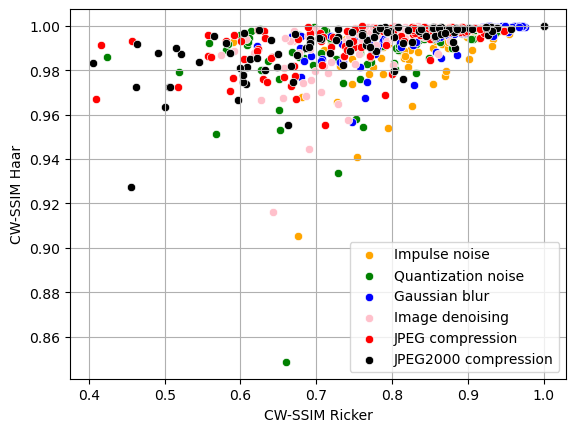

In [49]:
sns.scatterplot(x=y_r[5], y=y_h[5], marker='o', color='orange', label='Impulse noise')
sns.scatterplot(x=y_r[6], y=y_h[6], marker='o', color='green', label='Quantization noise')
sns.scatterplot(x=y_r[7], y=y_h[7], marker='o', color='blue', label='Gaussian blur')
sns.scatterplot(x=y_r[8], y=y_h[8], marker='o', color='pink', label='Image denoising')
sns.scatterplot(x=y_r[9], y=y_h[9], marker='o', color='red', label='JPEG compression')
sns.scatterplot(x=y_r[10], y=y_h[10], marker='o', color='black', label='JPEG2000 compression')
plt.xlabel('CW-SSIM Ricker')
plt.ylabel('CW-SSIM Haar')
plt.legend()
plt.grid(True)
plt.show()

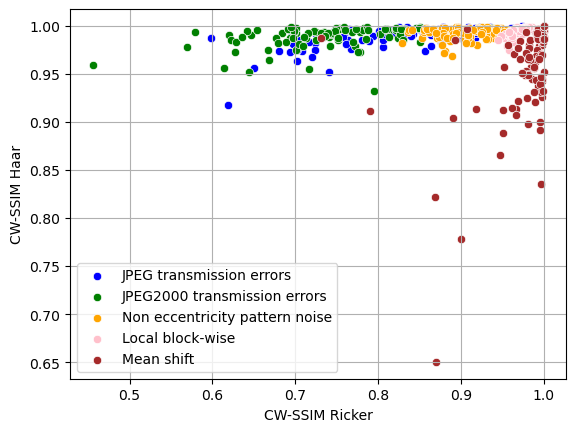

In [46]:
sns.scatterplot(x=y_r[11], y=y_h[11], marker='o', color='blue', label='JPEG transmission errors')
sns.scatterplot(x=y_r[12], y=y_h[12], marker='o', color='green', label='JPEG2000 transmission errors')
sns.scatterplot(x=y_r[13], y=y_h[13], marker='o', color='orange', label='Non eccentricity pattern noise')
sns.scatterplot(x=y_r[14], y=y_h[14], marker='o', color='pink', label='Local block-wise')
sns.scatterplot(x=y_r[15], y=y_h[15], marker='o', color='brown', label='Mean shift')
plt.xlabel('CW-SSIM Ricker')
plt.ylabel('CW-SSIM Haar')
plt.legend()
plt.grid(True)
plt.show()

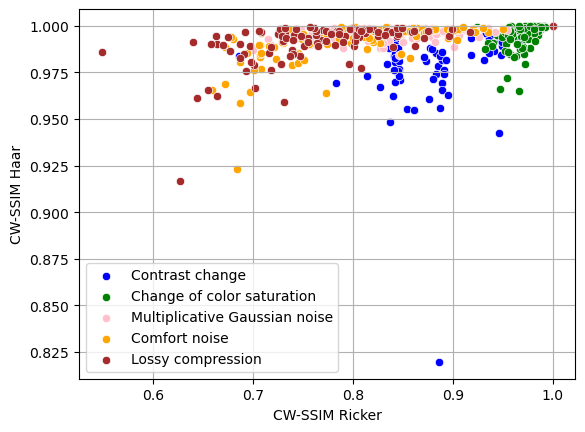

In [51]:
sns.scatterplot(x=y_r[16], y=y_h[16], marker='o', color='blue', label='Contrast change')
sns.scatterplot(x=y_r[17], y=y_h[17], marker='o', color='green', label='Change of color saturation')
sns.scatterplot(x=y_r[18], y=y_h[18], marker='o', color='pink', label='Multiplicative Gaussian noise')
sns.scatterplot(x=y_r[19], y=y_h[19], marker='o', color='orange', label='Comfort noise')
sns.scatterplot(x=y_r[20], y=y_h[20], marker='o', color='brown', label='Lossy compression')
plt.xlabel('CW-SSIM Ricker')
plt.ylabel('CW-SSIM Haar')
plt.legend()
plt.grid(True)
plt.show()

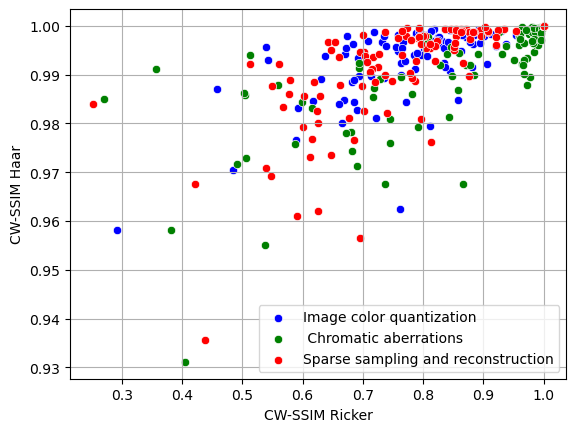

In [48]:
sns.scatterplot(x=y_r[21], y=y_h[21], marker='o', color='blue', label='Image color quantization')
sns.scatterplot(x=y_r[22], y=y_h[22], marker='o', color='green', label=' Chromatic aberrations')
sns.scatterplot(x=y_r[23], y=y_h[23], marker='o', color='red', label='Sparse sampling and reconstruction')
plt.xlabel('CW-SSIM Ricker')
plt.ylabel('CW-SSIM Haar')
plt.legend()
plt.grid(True)
plt.show()

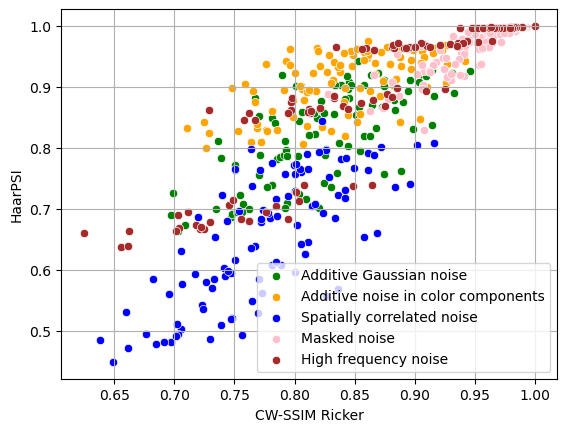

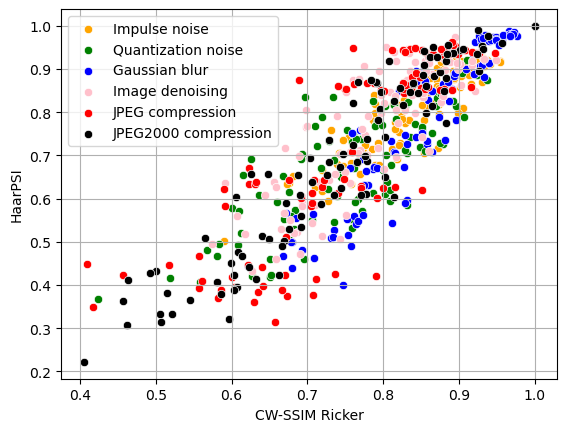

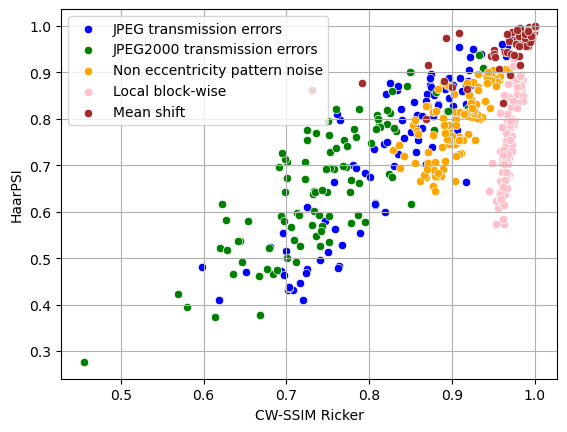

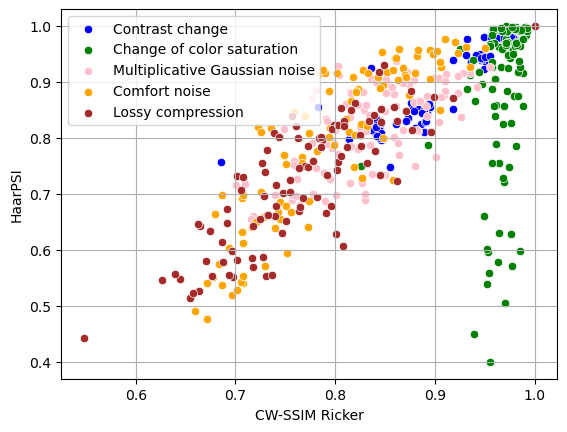

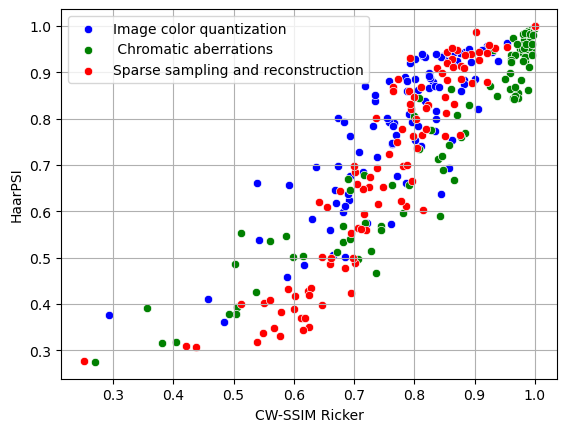

In [52]:
sns.scatterplot(x=y_r[0], y=y_p[0], marker='o', color='green', label='Additive Gaussian noise')
sns.scatterplot(x=y_r[1], y=y_p[1], marker='o', color='orange', label='Additive noise in color components')
sns.scatterplot(x=y_r[2], y=y_p[2], marker='o', color='blue', label='Spatially correlated noise')
sns.scatterplot(x=y_r[3], y=y_p[3], marker='o', color='pink', label='Masked noise')
sns.scatterplot(x=y_r[4], y=y_p[4], marker='o', color='brown', label='High frequency noise')
plt.xlabel('CW-SSIM Ricker')
plt.ylabel('HaarPSI')
plt.legend()
plt.grid(True)
plt.show()

sns.scatterplot(x=y_r[5], y=y_p[5], marker='o', color='orange', label='Impulse noise')
sns.scatterplot(x=y_r[6], y=y_p[6], marker='o', color='green', label='Quantization noise')
sns.scatterplot(x=y_r[7], y=y_p[7], marker='o', color='blue', label='Gaussian blur')
sns.scatterplot(x=y_r[8], y=y_p[8], marker='o', color='pink', label='Image denoising')
sns.scatterplot(x=y_r[9], y=y_p[9], marker='o', color='red', label='JPEG compression')
sns.scatterplot(x=y_r[10], y=y_p[10], marker='o', color='black', label='JPEG2000 compression')
plt.xlabel('CW-SSIM Ricker')
plt.ylabel('HaarPSI')
plt.legend()
plt.grid(True)
plt.show()

sns.scatterplot(x=y_r[11], y=y_p[11], marker='o', color='blue', label='JPEG transmission errors')
sns.scatterplot(x=y_r[12], y=y_p[12], marker='o', color='green', label='JPEG2000 transmission errors')
sns.scatterplot(x=y_r[13], y=y_p[13], marker='o', color='orange', label='Non eccentricity pattern noise')
sns.scatterplot(x=y_r[14], y=y_p[14], marker='o', color='pink', label='Local block-wise')
sns.scatterplot(x=y_r[15], y=y_p[15], marker='o', color='brown', label='Mean shift')
plt.xlabel('CW-SSIM Ricker')
plt.ylabel('HaarPSI')
plt.legend()
plt.grid(True)
plt.show()

sns.scatterplot(x=y_r[16], y=y_p[16], marker='o', color='blue', label='Contrast change')
sns.scatterplot(x=y_r[17], y=y_p[17], marker='o', color='green', label='Change of color saturation')
sns.scatterplot(x=y_r[18], y=y_p[18], marker='o', color='pink', label='Multiplicative Gaussian noise')
sns.scatterplot(x=y_r[19], y=y_p[19], marker='o', color='orange', label='Comfort noise')
sns.scatterplot(x=y_r[20], y=y_p[20], marker='o', color='brown', label='Lossy compression')
plt.xlabel('CW-SSIM Ricker')
plt.ylabel('HaarPSI')
plt.legend()
plt.grid(True)
plt.show()

sns.scatterplot(x=y_r[21], y=y_p[21], marker='o', color='blue', label='Image color quantization')
sns.scatterplot(x=y_r[22], y=y_p[22], marker='o', color='green', label=' Chromatic aberrations')
sns.scatterplot(x=y_r[23], y=y_p[23], marker='o', color='red', label='Sparse sampling and reconstruction')
plt.xlabel('CW-SSIM Ricker')
plt.ylabel('HaarPSI')
plt.legend()
plt.grid(True)
plt.show()

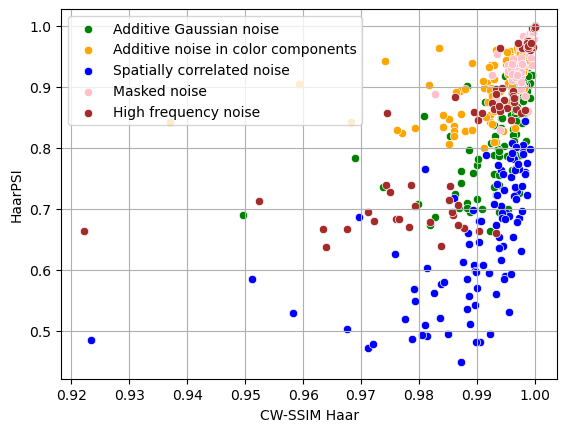

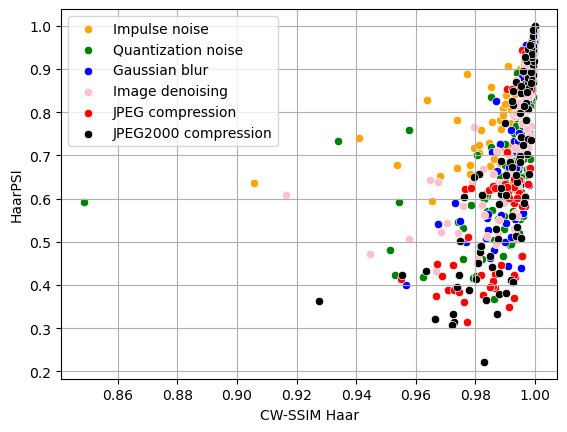

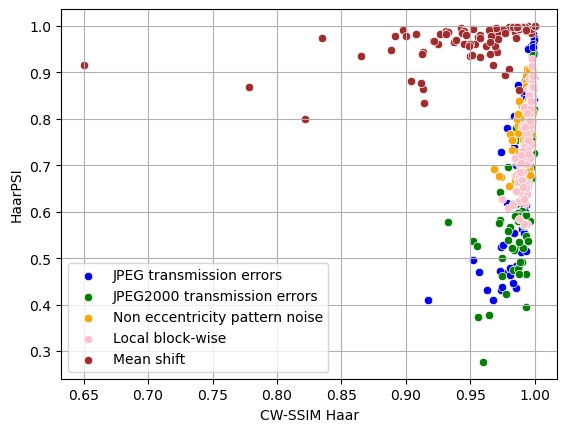

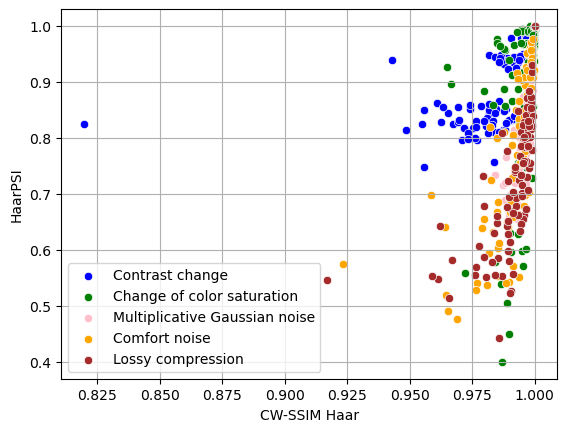

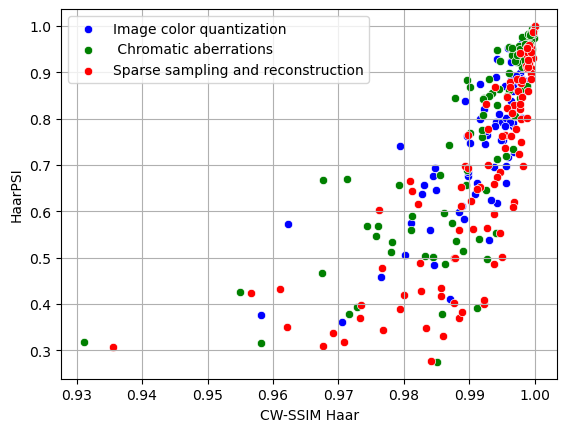

In [53]:
sns.scatterplot(x=y_h[0], y=y_p[0], marker='o', color='green', label='Additive Gaussian noise')
sns.scatterplot(x=y_h[1], y=y_p[1], marker='o', color='orange', label='Additive noise in color components')
sns.scatterplot(x=y_h[2], y=y_p[2], marker='o', color='blue', label='Spatially correlated noise')
sns.scatterplot(x=y_h[3], y=y_p[3], marker='o', color='pink', label='Masked noise')
sns.scatterplot(x=y_h[4], y=y_p[4], marker='o', color='brown', label='High frequency noise')
plt.xlabel('CW-SSIM Haar')
plt.ylabel('HaarPSI')
plt.legend()
plt.grid(True)
plt.show()

sns.scatterplot(x=y_h[5], y=y_p[5], marker='o', color='orange', label='Impulse noise')
sns.scatterplot(x=y_h[6], y=y_p[6], marker='o', color='green', label='Quantization noise')
sns.scatterplot(x=y_h[7], y=y_p[7], marker='o', color='blue', label='Gaussian blur')
sns.scatterplot(x=y_h[8], y=y_p[8], marker='o', color='pink', label='Image denoising')
sns.scatterplot(x=y_h[9], y=y_p[9], marker='o', color='red', label='JPEG compression')
sns.scatterplot(x=y_h[10], y=y_p[10], marker='o', color='black', label='JPEG2000 compression')
plt.xlabel('CW-SSIM Haar')
plt.ylabel('HaarPSI')
plt.legend()
plt.grid(True)
plt.show()

sns.scatterplot(x=y_h[11], y=y_p[11], marker='o', color='blue', label='JPEG transmission errors')
sns.scatterplot(x=y_h[12], y=y_p[12], marker='o', color='green', label='JPEG2000 transmission errors')
sns.scatterplot(x=y_h[13], y=y_p[13], marker='o', color='orange', label='Non eccentricity pattern noise')
sns.scatterplot(x=y_h[14], y=y_p[14], marker='o', color='pink', label='Local block-wise')
sns.scatterplot(x=y_h[15], y=y_p[15], marker='o', color='brown', label='Mean shift')
plt.xlabel('CW-SSIM Haar')
plt.ylabel('HaarPSI')
plt.legend()
plt.grid(True)
plt.show()

sns.scatterplot(x=y_h[16], y=y_p[16], marker='o', color='blue', label='Contrast change')
sns.scatterplot(x=y_h[17], y=y_p[17], marker='o', color='green', label='Change of color saturation')
sns.scatterplot(x=y_h[18], y=y_p[18], marker='o', color='pink', label='Multiplicative Gaussian noise')
sns.scatterplot(x=y_h[19], y=y_p[19], marker='o', color='orange', label='Comfort noise')
sns.scatterplot(x=y_h[20], y=y_p[20], marker='o', color='brown', label='Lossy compression')
plt.xlabel('CW-SSIM Haar')
plt.ylabel('HaarPSI')
plt.legend()
plt.grid(True)
plt.show()

sns.scatterplot(x=y_h[21], y=y_p[21], marker='o', color='blue', label='Image color quantization')
sns.scatterplot(x=y_h[22], y=y_p[22], marker='o', color='green', label=' Chromatic aberrations')
sns.scatterplot(x=y_h[23], y=y_p[23], marker='o', color='red', label='Sparse sampling and reconstruction')
plt.xlabel('CW-SSIM Haar')
plt.ylabel('HaarPSI')
plt.legend()
plt.grid(True)
plt.show()

In [47]:
for i in x

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24]

In [44]:
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'pink', 'purple', 'brown', 
          'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'pink', 'purple', 'brown']
markers = ['o', '^', 's', '*', 'D', 'X', 'P', 'H', 'v', '<', '>', 'd',
           'o', '^', 's', '*', 'D', 'X', 'P', 'H', 'v', '<', '>', 'd']